In [1]:
import torch

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.nn import Module, Conv2d, MaxPool2d, Flatten, Linear, CrossEntropyLoss
from torch.nn.functional import relu, softmax
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = CIFAR10(root="data", train=True, download=True, transform=ToTensor())
test = CIFAR10(root="data", train=False, download=True, transform=ToTensor())

In [3]:
train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [6]:
train.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [7]:
name_list = ["airplane", "car", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"]

In [8]:
train.data[0].shape

(32, 32, 3)

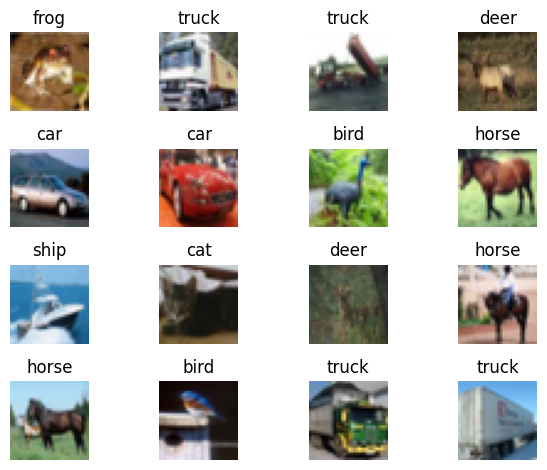

In [9]:
# 간단한 eda
for idx, image in enumerate(train.data[:16]):
    plt.subplot(4, 4, idx+1)
    plt.imshow(image)
    plt.title(name_list[train.targets[idx]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
batch_size = 4
trainset = DataLoader(train, batch_size, shuffle=True)

In [11]:
testset = DataLoader(test, batch_size, shuffle=True)

In [12]:
class CNN(Module):
    def __init__(self):
        super().__init__()

        # Conv2d(input channel, output channel, kernel)
        self.conv1 = Conv2d(3, 6, 5)
        self.conv2 = Conv2d(6, 16, 5)
        self.pool = MaxPool2d(2, 2)

        self.flatten = Flatten()
        # 32 * 32 -> 28 * 28 -> 14 * 14 -> 10 * 10 -> 5 * 5
        #Linear(input, output)
        self.layer01 = Linear(16 * 5 * 5, 120)
        self.layer02 = Linear(120, 64)
        self.layer03 = Linear(64, 10)


    def forward(self, x):
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))

        x = self.flatten(x)
        x = relu(self.layer01(x))
        x = relu(self.layer02(x))
        x = softmax(self.layer03(x), dim=1)

        return x

In [13]:
model = CNN()

In [15]:
loss_function = CrossEntropyLoss()

learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)

In [16]:
loss_list = list()

for epoch in range(5):
    running_loss = 0.0
    acc_cnt = 0
    correct = 0
    total = 0

    for i, data in enumerate(trainset):
        x_train, y_train = data

        # optimizer 초기화
        optimizer.zero_grad()

        # 순전파
        h = model(x_train)
        loss = loss_function(h, y_train)

        # 역전파
        loss.backward()

        # opt
        optimizer.step()

        loss - loss.item()
        loss_list.append(loss)

        if i % 1000 == 0:
            print(f"epoch: {epoch} ({i:5d}) \t loss : {loss:.3f}")

epoch: 0 (    0) 	 loss : 2.300
epoch: 0 ( 1000) 	 loss : 2.292
epoch: 0 ( 2000) 	 loss : 2.263
epoch: 0 ( 3000) 	 loss : 2.200
epoch: 0 ( 4000) 	 loss : 2.188
epoch: 0 ( 5000) 	 loss : 2.026
epoch: 0 ( 6000) 	 loss : 2.135
epoch: 0 ( 7000) 	 loss : 2.196
epoch: 0 ( 8000) 	 loss : 2.040
epoch: 0 ( 9000) 	 loss : 2.325
epoch: 0 (10000) 	 loss : 2.366
epoch: 0 (11000) 	 loss : 1.711
epoch: 0 (12000) 	 loss : 2.156
epoch: 1 (    0) 	 loss : 1.935
epoch: 1 ( 1000) 	 loss : 1.959
epoch: 1 ( 2000) 	 loss : 2.115
epoch: 1 ( 3000) 	 loss : 1.969
epoch: 1 ( 4000) 	 loss : 2.407
epoch: 1 ( 5000) 	 loss : 2.407
epoch: 1 ( 6000) 	 loss : 2.428
epoch: 1 ( 7000) 	 loss : 1.930
epoch: 1 ( 8000) 	 loss : 1.831
epoch: 1 ( 9000) 	 loss : 2.025
epoch: 1 (10000) 	 loss : 2.077
epoch: 1 (11000) 	 loss : 2.191
epoch: 1 (12000) 	 loss : 1.943
epoch: 2 (    0) 	 loss : 2.106
epoch: 2 ( 1000) 	 loss : 1.710
epoch: 2 ( 2000) 	 loss : 2.278
epoch: 2 ( 3000) 	 loss : 1.716
epoch: 2 ( 4000) 	 loss : 2.177
epoch: 2

In [17]:
test_iter = iter(testset)
x_test, y_test = next(test_iter)

In [18]:
predict = model(x_test)
predict

tensor([[2.4196e-12, 7.8384e-13, 1.7100e-12, 9.2624e-03, 5.2603e-17, 1.2487e-10,
         1.0218e-08, 1.3217e-07, 8.1717e-04, 9.8992e-01],
        [4.4754e-05, 2.3073e-07, 2.4826e-01, 6.3460e-04, 7.5066e-01, 3.7132e-04,
         1.5404e-05, 1.1725e-05, 1.3217e-07, 1.6585e-07],
        [2.8427e-17, 1.3125e-06, 4.9097e-21, 1.0835e-18, 1.5339e-25, 2.7693e-27,
         1.4497e-26, 8.5553e-27, 9.9687e-01, 3.1320e-03],
        [1.3294e-10, 4.1335e-04, 9.2531e-01, 1.0801e-09, 3.3662e-08, 7.3781e-02,
         8.5841e-13, 4.9627e-04, 6.0502e-16, 1.1495e-08]],
       grad_fn=<SoftmaxBackward0>)

In [20]:
_, predict_labels = torch.max(predict, 1)
print(predict_labels)
print(y_test)
# _ : 첫번째로 리턴되는 값은 사용하지않겠다

tensor([9, 4, 8, 2])
tensor([7, 7, 1, 3])


In [21]:
# 리턴값 확인하기
torch.max(predict, 1)

torch.return_types.max(
values=tensor([0.9899, 0.7507, 0.9969, 0.9253], grad_fn=<MaxBackward0>),
indices=tensor([9, 4, 8, 2]))

In [22]:
# 모델 평가

In [25]:
correct = 0
total = 0

# no_grad : 기울기 계산 X
with torch.no_grad():
    for data in testset:
        x_test, y_test = data
        h = model(x_test)
        _, predicted = torch.max(h.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

print(f"acc : {100 * correct // total}")
# 기울기 계산을 안하는 이유는 가중치를 바꾸면 안되기때문에. 모델 학습이 아니라 검증이라서 w랑 b가 변하면 안됨

acc : 37
